# Strawberry Fields Forever  

_**exploring climate change impact on strawberry farming in Finland**_

**NOTE: This is a proof of concept**

*For "real" more effort is needed to ensure data correctness, addressing bias - and overall refactoring so that the script can be run as a whole. Furthermore, the specifics of strawberries from https://lansi-suomi.proagria.fi/sites/default/files/attachment/m._rantanen_mansikan_kukka-aiheiden_kehitys.pdf and N. Opstad et.al. /Scientia Horticuluturae 129 (2011) 127-134 should be integrated and some statistical analysis done*

Content

* [Purpose](#Purpose)
* [Data](#Data)
* [Explore Data](#explore_data)
* [Chosen Regions](#chosen_regions)
* [Explore by Region](#explore_region)
    * [Standard workflow](#explore_region_std)
    * [2011-2099 quick fix](#explore_region_long)
    * [Combine Data](#combine_data)
* [Mean Daily Temperature](#mean_daily_temp)
    * [2011-2099](#mean_daily_temp_2011_2099)
    * [2011-2041](#mean_daily_temp_2011_2041)
* [Accumulated temperature sum](#accum_temp_sum)
    * [Full year](#accum_temp_year)
    * [1st of May - 31 August - 2011-2099](#accum_temp_2011_2099)
    * [1st of May - 31 August - 2011-2041](#accum_temp_2011_2041)


* [Seasons for one lat/lon point only - experiment](#point_experiment)

# Purpose

Explore how climate change is expected to impact farming of strawberries in the South of Finland
(south from Tampere).

It is expected that strawberry varieties may have to change to better accommodate the 
projected climate over coming several decades.

Data for the study is from

* Agroclimatic Indicators / Copernicus Data Store (https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroclimatic-indicators?tab=overviewac)
* Key parameters for different strawberry varieties (tbd)



# Data

## Agroclimatic indicators

### Overview

As described in https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroclimatic-indicators?tab=overview

>This dataset provides agroclimatic indicators used to characterise plant-climate interactions for global agriculture. Agroclimatic indicators are useful in conveying climate variability and change in the terms that are meaningful to the agricultural sector. The objective of this dataset is to provide these indicators at a global scale in an easily accessible and usable format for further downstream analysis and the forcing of agricultural impact models.

>ERA-interim reanalysis and bias-corrected climate datasets have been used to generate the agroclimatic indicators for historical and future time periods. The input data was provided through the Inter-Sectoral Impact Model Intercomparison Project (ISIMIP), of which the ISIMIP Fast Track product was used. This product contains daily, biased-corrected, climate data from 5 CMIP5 General Circulation Models covering the period 1951-2099 (historical run up to 2005). The agroclimatic indicators were also generated using the WFDEI (Watch Forcing Data methodology applied to ERA-Interim) for the 1981-2010 climatological period. A total of 26 indicators are provided in this dataset at a spatial resolution of 0.5°x0.5° on a lat-lon grid. The temporal resolution of the variables differs depending on the indicator - they are available at 10 consecutive days (10-day), seasonal or annual resolution.

Details and usage guide of teh data set available as a separate pfd http://datastore.copernicus-climate.eu/documents/sis-global-agriculture/C3S422Lot1.WEnR.DS1_ProductUserGuideSpecification_v2.0.pdf

### Selected models

Data was chosen from the RCP4.5 experiment of all five models for the period from 
2011 up until end of 2070 (decadal, i.e. 10 days data up to 2041 only due to volume constraints)

* IPSL-CM5A-LR Model (IPSL, France)
* NorESM1-M Model (NCC, Norway)
* HadGEM2-ES Model (UK Met Office, UK)

The following were not used as they were not from Europe and therefore 
did not have necessarily Finland relevant focus  

* MIROC-ESM-CHEM Model (JAMSTEC, Japan)
* GFDL-ESM2M Model (NOAA, USA)

Several models were used to better understand uncertainty in projections.

In [1]:
model_list = [
    'NorESM1-M', 
#    'MIROC-ESM-CHEM', 
#    'GFDL-ESM2M', 
    'IPSL-CM5A-LR', 
    'HadGEM2-ES'
]

### Annual variables

This was not used as the definition was quite ambiguous in user manual. And it did not really match
the needs of our study as we needed data that we can relate to strawberries.

* GSL - Length of growing season

In [2]:
var_list_yr = ['GSL'] 


### Seasonal variables

Seasonal resolution data was available for the following variables

* Maximum number of consecutive dry days
* Maximum number of consecutive frost days
* Cold spell duration index
* Maximum number of consecutive summer days
* Maximum number of consecutive wet 
* Warm spell duration index
* Warm and wet days

However, in the end we did not use this data since it was hard to use in our context.

In [3]:
var_list_seasonal = ['CDD', 'CFD', 'CSDI', 'CSU', 'CWD', 'WSDI', 'WW']

Seasonal data has one value for each of the four three month  periods annually

* MAM - March, April, May
* JJA - June, July, August
* SON - September, October, November
* DJF - December, January, February

### Decadal variables (10 days aggregation)

In [4]:
var_list_dekadal_all = ['BEDD', 'DTR', 'RR', 'TG', 'TNn', 'TNx', 'TN', 'TXn', 'TXx', 'TX']
var_list_dekadal = ['TG', 'TX']


Out of the list we ended up using only two which we could easily use

* TG - Mean of daily mean temperature for the calculation of growing degree days
* TX - Mean of daily maximum temperature

The use of precipitation related or frost related variables might be useful in later studies, but not enough time for that nowe

### Processing

Data of each model was downloaded as zip files from CDS. It was provided as separate files which were consolidated into one for
ease of futher processing.

Note: Consolidation of netCDF4 files has issues which had to be resolved using a workaround
described at     # https://github.com/pydata/xarray/issues/2921

Even with that workaround one had to adjust dates of TX separately to get the results to
right range since TX and TG had issues of their own.
Or, to be frank, there was no time to build up enough expertise in the toolset 
and its proper use within constraints of time.


In [5]:
# root file for data, source files for different models in separate subfolders each
# combined files created into the root folder
#
# data_folder
#      |
#      +--/NorESM1-M
#      +--/IPSL-CM5A-LR
#      +--/HadGEM2-ES
#
data_folder = 'D:/Users/Juha/Ana/MyData/climate/strawberries/'

# going to create combined files or not?
do_combine = False
do_check = False
read_cache = True

# some libraries we need
import matplotlib.pyplot as plt
# plots into the notebook
%matplotlib inline 
import seaborn as sns
import pandas as pd
import numpy as np
import os
import importlib
import strawberry as sbry

* * *

**Year**


In [6]:
if do_check: sbry.check_model_files(data_folder, model_list[1], '_yr_', True)

* * *

**Season**


In [7]:
if do_check: sbry.check_model_files(data_folder, model_list[1], '_season_')

* * *

**Dekadal**


In [8]:
if do_check: sbry.check_model_files(data_folder, model_list[1], '_dek_')

### Combining netCDF files

Can be done with the script here. 
But there are issues in combining the netCDF4 files 
and therefore there are a few 
quick and dirty adjustments later down in the script.

The unzipped files from Copernicus are assumed to be in subfolders named by the name of the model.
Combined files - if created - will be in the root folder.

Note that combining files can take qute some time, depending on CPU speed and memory
available


In [9]:
# combining TG and TX together - takes a lot of time, do once pnly and use the cpmbined file later on
do_combine = False
if do_combine:
    for amodel in model_list:
        for avar in ['TX', 'TG']:
            print('\n\nCombining %s - feature %s\n\n' % (amodel, avar))
            sbry.combine_to_netCDF4(
                data_folder,
                amodel,
                'dek',
                avar
            )
        

# Explore data<a id='explore_data'></a>

Working out first version of analysis using

* one coordinate point: Tampere lat = 61.4978° N, lon = 23.7610° E
* separate trend for each of the four seasons: JFM, AMJ, JAS, OND


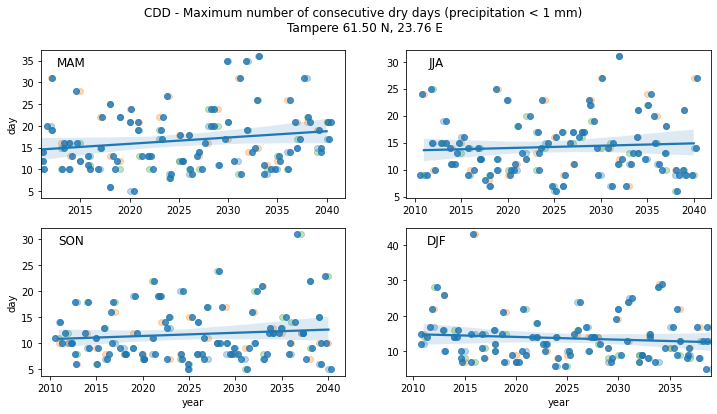

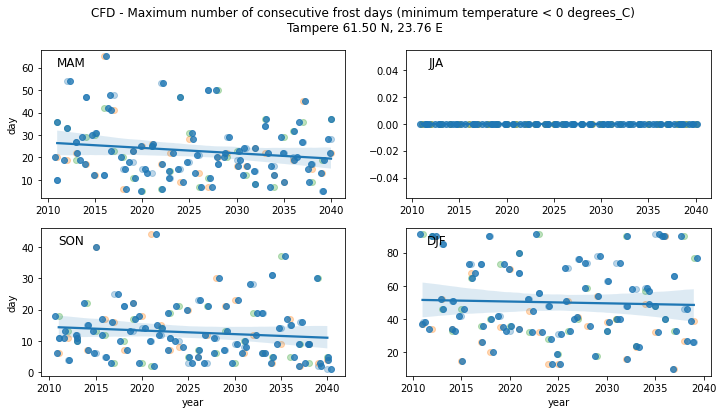

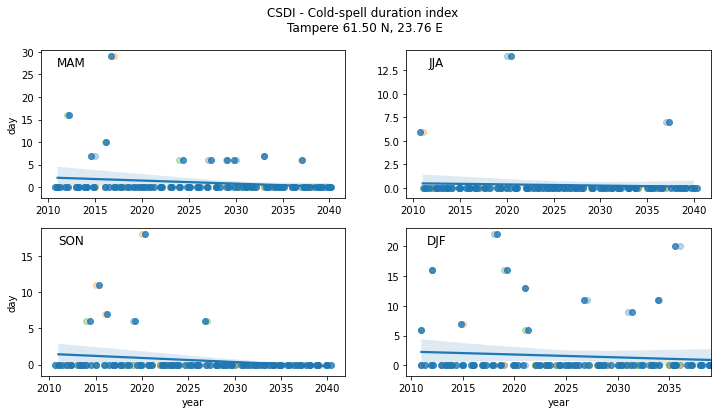

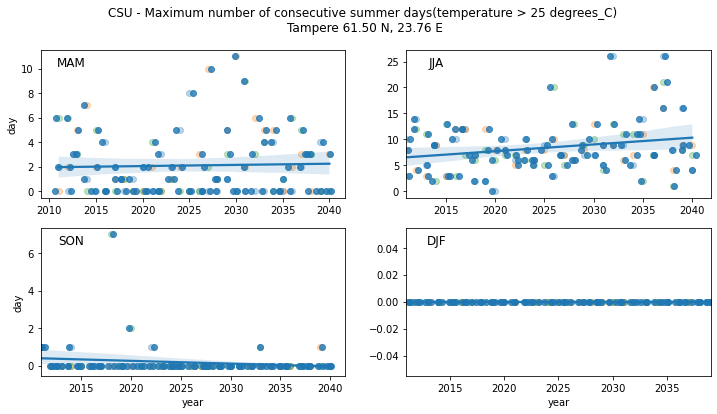

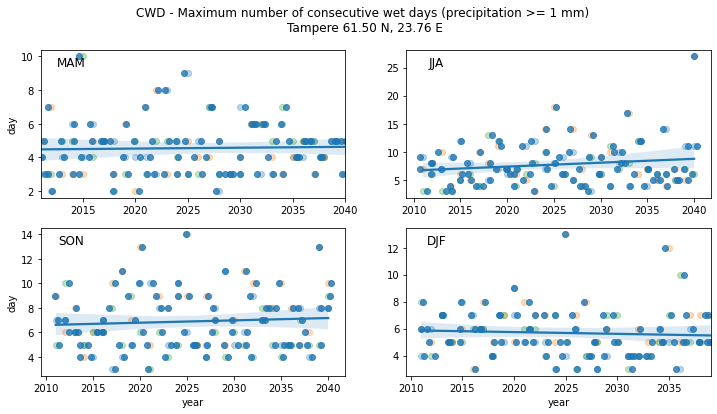

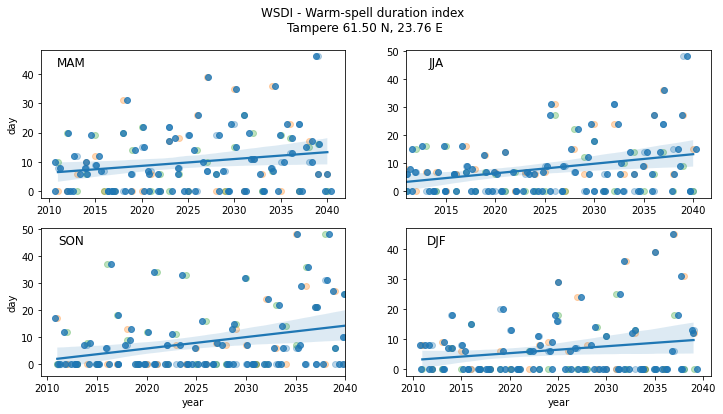

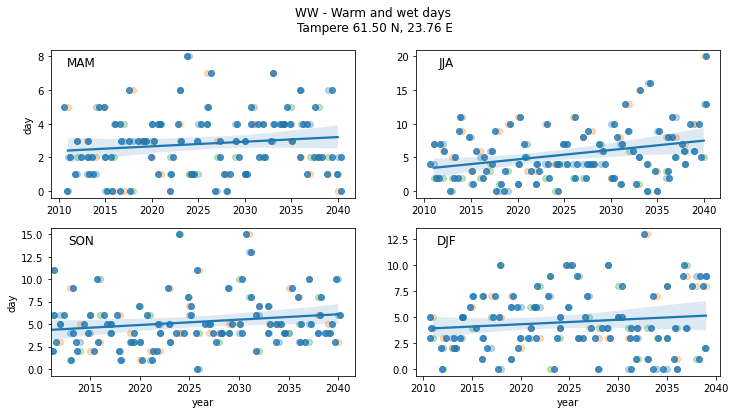

In [10]:
geopoint_name = 'Tampere'
geopoint_lat = 61.4978
geopoint_lon = 23.7610

plt.rcParams['figure.figsize'] = [12, 6]
                                
#sbry.do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name, '20410101-20701231') # NOTE: wrong start year shown
sbry.do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name, '20110101-20401231')
#sbry.do_model_variable(data_folder, model_list, var_list_seasonal, geopoint_lat, geopoint_lon, geopoint_name)    

# Chosen regions<a id='chosen_regions'></a>

Getting data for three separate regions of strawberry farming


* * *

Häme

![Häme](img/map_hame.png)

Koski TL

* 60.655
* 23.141667

Padasjoki

* 61.35000000
* 25.28333000

* * *

Pohjois Savo

![Pohjois Savo](img/map_psavo.png)

Hankasalmi

* 62.38666512 
* 26.43499826

Valtimo

* 63.68
* 28.816667

* * *

Varsinais-Suomi

![Varsinais-Suomi](img/map_vsuomi.png)


Houtskär

* 60.2167
* 21.3833

Alastaro

* 60.97424 
* 22.65558


In [11]:
# defien areas

geo_hame = {
    'name':'Häme',
    'tag': 'hame',
    'gp1': {
        'name':'Koski TL',
        'lat_lon':[60.655, 23.141667]
    },
    'gp2': {
        'name':'Padasjoki',
        'lat_lon':[61.35000000, 25.28333000]
    }
}
#geo_hame['gp2']['lat_lon'][1]

geo_psavo = {
    'name':'Pohjois-Savo',
    'tag': 'psavo',
    'gp1': {
        'name':'Hankasalmi',
        'lat_lon':[62.38666512 , 26.43499826]
    },
    'gp2': {
        'name':'Valtimo',
        'lat_lon':[63.68, 28.816667]
    }
}

geo_vsuomi = {
    'name':'Varsinais-Suomi',
    'tag': 'vsuomi',
    'gp1': {
        'name':'Houtskär',
        'lat_lon':[60.2167 , 21.3833]
    },
    'gp2': {
        'name':'Alastaro',
        'lat_lon':[60.97424, 22.65558]
    }
}


# Explore by Region <a id='explore_region'></a>

Exploring by region and generating basic data summaries for later use


## Explore 2011-2041 <a id='explore_region_std'></a>

Standard workflow for regions


In [13]:
df_yr_psavo =  sbry.get_region_data(
    geo_psavo,
    'yr',
    model_list,
    var_list_yr,
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_season_psavo =  sbry.get_region_data(
    geo_psavo,
    'season',
    model_list,
    var_list_seasonal, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_dekadal_psavo =  sbry.get_region_data(
    geo_psavo,
    'dek',
    model_list,
    var_list_dekadal_all, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_yr_psavo.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_season_psavo.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_psavo.pkl


In [14]:
df_season_psavo.loc[df_season_psavo['var_id'] == 'CDD'].head()

,var_id,var_name,var_unit,var,time,days_from1860,model,days_from1860_td,datetime,datetime_int,datetime_date
0,CDD,Maximum number of consecutive dry days (precip...,day,8.866667,0,55257.0,NorESM1-M,55257 days,2011-04-16,1.302912e+09,2011-04-16
1,CDD,Maximum number of consecutive dry days (precip...,day,10.600000,1,55348.0,NorESM1-M,55348 days,2011-07-16,1.310774e+09,2011-07-16
2,CDD,Maximum number of consecutive dry days (precip...,day,11.800000,2,55440.0,NorESM1-M,55440 days,2011-10-16,1.318723e+09,2011-10-16
3,CDD,Maximum number of consecutive dry days (precip...,day,9.000000,3,55532.0,NorESM1-M,55532 days,2012-01-16,1.326672e+09,2012-01-16
4,CDD,Maximum number of consecutive dry days (precip...,day,14.600000,4,55623.0,NorESM1-M,55623 days,2012-04-16,1.334534e+09,2012-04-16


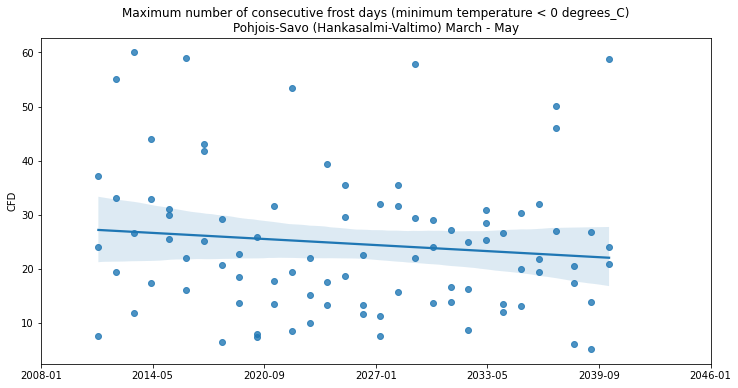

In [15]:
df = df_season_psavo.loc[
    (df_season_psavo['var_id'] == var_list_seasonal[1]) &
    (df_season_psavo['datetime'].dt.month == 4) 
]

ax = plt.gca()
sns.regplot(
    x = 'datetime_int',
    y = 'var',
    data = df,
    ax=ax
)
xticks = ax.get_xticks()
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
xticks_dates = [pd.to_datetime(x*10**9).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xlabel('')
plt.title(df['var_name'][0] + '\n' + sbry.get_region_title(geo_psavo) + ' March - May')
plt.ylabel(df['var_id'][0])
plt.show()

In [16]:
df_season_psavo.head()

,var_id,var_name,var_unit,var,time,days_from1860,model,days_from1860_td,datetime,datetime_int,datetime_date
0,CDD,Maximum number of consecutive dry days (precip...,day,8.866667,0,55257.0,NorESM1-M,55257 days,2011-04-16,1.302912e+09,2011-04-16
1,CDD,Maximum number of consecutive dry days (precip...,day,10.600000,1,55348.0,NorESM1-M,55348 days,2011-07-16,1.310774e+09,2011-07-16
2,CDD,Maximum number of consecutive dry days (precip...,day,11.800000,2,55440.0,NorESM1-M,55440 days,2011-10-16,1.318723e+09,2011-10-16
3,CDD,Maximum number of consecutive dry days (precip...,day,9.000000,3,55532.0,NorESM1-M,55532 days,2012-01-16,1.326672e+09,2012-01-16
4,CDD,Maximum number of consecutive dry days (precip...,day,14.600000,4,55623.0,NorESM1-M,55623 days,2012-04-16,1.334534e+09,2012-04-16


In [17]:
dfx = df_season_psavo.copy()

dfx['mth'] = pd.DatetimeIndex(dfx['datetime']).month

dfx.groupby(['mth', 'var_id']).count()

var_name  var_unit  var  time  days_from1860  model  \
mth var_id                                                        
1   CDD           87        87   87    87             87     87   
    CFD           87        87   87    87             87     87   
    CSDI          87        87   87    87             87     87   
    CSU           87        87   87    87             87     87   
    CWD           87        87   87    87             87     87   
    WSDI          87        87   87    87             87     87   
    WW            87        87   87    87             87     87   
4   CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   
7   CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   
10  CDD           90        90   90    90             90     90   
    CFD           90        90   90    90             90     90   
    CSDI          90        90   90    90             90     90   
    CSU           90        90   90    90             90     90   
    CWD           90        90   90    90             90     90   
    WSDI          90        90   90    90             90     90   
    WW            90        90   90    90             90     90   

            days_from1860_td  datetime  datetime_int  datetime_date  
mth var_id                                                           
1   CDD                   87        87            87             87  
    CFD                   87        87            87             87  
    CSDI                  87        87            87             87  
    CSU                   87        87            87             87  
    CWD                   87        87            87             87  
    WSDI                  87        87            87             87  
    WW                    87        87            87             87  
4   CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90            90             90  
    WW                    90        90            90             90  
7   CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90            90             90  
    WW                    90        90            90             90  
10  CDD                   90        90            90             90  
    CFD                   90        90            90             90  
    CSDI                  90        90            90             90  
    CSU                   90        90            90             90  
    CWD                   90        90            90             90  
    WSDI                  90        90   

   var_id                                           var_name var_unit  \
0     CDD  Maximum number of consecutive dry days (precip...      day   
4     CDD  Maximum number of consecutive dry days (precip...      day   
8     CDD  Maximum number of consecutive dry days (precip...      day   
12    CDD  Maximum number of consecutive dry days (precip...      day   
16    CDD  Maximum number of consecutive dry days (precip...      day   

          var  time  days_from1860      model days_from1860_td   datetime  \
0    8.866667     0        55257.0  NorESM1-M       55257 days 2011-04-16   
4   14.600000     4        55623.0  NorESM1-M       55623 days 2012-04-16   
8   12.200000     8        55988.0  NorESM1-M       55988 days 2013-04-16   
12  12.600000    12        56353.0  NorESM1-M       56353 days 2014-04-16   
16   9.866667    16        56718.0  NorESM1-M       56718 days 2015-04-16   

    datetime_int datetime_date  
0   1.302912e+09    2011-04-16  
4   1.334534e+09    2012-04-16  

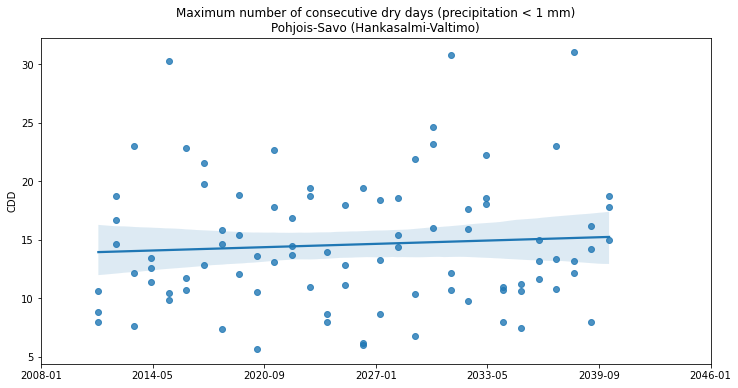

In [18]:
df = df_season_psavo.loc[
    (df_season_psavo['var_id'] == var_list_seasonal[0]) &
    ((df_season_psavo['datetime'].dt.month == 4))
]

print(df.head())

ax = plt.gca()
sns.regplot(
    x = 'datetime_int',
    y = 'var',
    data = df,
    ax=ax
)
xticks = ax.get_xticks()
ax.set_xticks(ax.get_xticks().tolist()) # REMOVE IN THE FUTURE - PLACED TO AVOID WARNING - IT IS A BUG FROM MATPLOTLIB 3.3.1
xticks_dates = [pd.to_datetime(x*10**9).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)
plt.xlabel('')
plt.title(df['var_name'].iloc[0] + '\n' + sbry.get_region_title(geo_psavo) )
plt.ylabel(df['var_id'].iloc[0])
plt.show()

In [19]:
# häme

df_yr_hame =  sbry.get_region_data(
    geo_hame,
    'yr',
    model_list,
    var_list_yr,
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_season_hame =  sbry.get_region_data(
    geo_hame,
    'season',
    model_list,
    var_list_seasonal, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_dekadal_hame =  sbry.get_region_data(
    geo_hame,
    'dek',
    model_list,
    var_list_dekadal_all, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_yr_hame.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_season_hame.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_hame.pkl


In [20]:
# vsuomi

df_yr_vsuomi =  sbry.get_region_data(
    geo_vsuomi,
    'yr',
    model_list,
    var_list_yr,
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_season_vsuomi =  sbry.get_region_data(
    geo_vsuomi,
    'season',
    model_list,
    var_list_seasonal, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

df_dekadal_vsuomi =  sbry.get_region_data(
    geo_vsuomi,
    'dek',
    model_list,
    var_list_dekadal_all, 
    '20110101-20401231',
    data_folder,
    '',
    read_cache = read_cache
)

read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_yr_vsuomi.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_season_vsuomi.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_vsuomi.pkl


In [30]:
importlib.reload(sbry)

df_yr = pd.concat([
    sbry.add_ids(df_yr_psavo, 'psavo', 'yr'),
    sbry.add_ids(df_yr_vsuomi, 'vsuomi', 'yr'),
    sbry.add_ids(df_yr_hame, 'hame', 'yr')
    ])
df_yr.head()

# Seasonal

df_season = pd.concat([
    sbry.add_ids(df_season_psavo, 'psavo', 'season'),
    sbry.add_ids(df_season_vsuomi, 'vsuomi', 'season'),
    sbry.add_ids(df_season_hame, 'hame', 'season')
])
df_season.head()

# Dekadal

df_dekadal = pd.concat([
    sbry.add_ids(df_dekadal_psavo, 'psavo', 'dekadal'),
    sbry.add_ids(df_dekadal_vsuomi, 'vsuomi', 'dekadal'),
    sbry.add_ids(df_dekadal_hame, 'hame', 'dekadal')
])
df_dekadal.head()

df_all = pd.concat([
    df_yr, 
    df_season, 
    df_dekadal
])

df_all.groupby(['region', 'srctype', 'var_id'])['var'].count()


region  srctype  var_id
hame    dekadal  BEDD      3240
                 DTR       3240
                 RR        3240
                 TG        3240
                 TN        3240
                 TNn       3240
                 TNx       3240
                 TX        3240
                 TXn       3240
                 TXx       3240
        season   CDD        357
                 CFD        357
                 CSDI       357
                 CSU        357
                 CWD        357
                 WSDI       357
                 WW         357
        yr       GSL         90
psavo   dekadal  BEDD      3240
                 DTR       3240
                 RR        3240
                 TG        3240
                 TN        3240
                 TNn       3240
                 TNx       3240
                 TX        3240
                 TXn       3240
                 TXx       3240
        season   CDD        357
                 CFD        357
                

## TX and TG dekadal data for 2011-2099 <a id='explore_region_long'></a>

Essential variables for the strawberry study 

In [27]:
importlib.reload(sbry)

df_dekadal_long_psavo_txtg =  sbry.get_region_data(
    geo_psavo,
    'dek',
    model_list,
    ['TX', 'TG'], 
    '',
    data_folder,
    '_long',
    read_cache = read_cache
)

df_dekadal_long_hame_txtg =  sbry.get_region_data(
    geo_hame,
    'dek',
    model_list,
    ['TX', 'TG'], 
    '',
    data_folder,
    '_long',
    read_cache = read_cache
)

df_dekadal_long_vsuomi_txtg =  sbry.get_region_data(
    geo_vsuomi,
    'dek',
    model_list,
    ['TX', 'TG'], 
    '',
    data_folder,
    '_long',
    read_cache = read_cache
)


read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_long_psavo.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_long_hame.pkl
read from cache D:/Users/Juha/Ana/MyData/climate/strawberries/df_dek_long_vsuomi.pkl


In [32]:
# Dekadal long

df_dekadal_long = pd.concat([
    sbry.add_ids(df_dekadal_long_psavo_txtg, 'psavo', 'dekadal'), 
    sbry.add_ids(df_dekadal_long_vsuomi_txtg, 'vsuomi', 'dekadal'), 
    sbry.add_ids(df_dekadal_long_hame_txtg, 'hame', 'dekadal')
])

print(df_dekadal_long.head())
print(df_dekadal_long.tail())


  var_id                           var_name var_unit         var  time  \
0     TX  Mean of daily maximum temperature        K  258.091709     0   
1     TX  Mean of daily maximum temperature        K  257.797017     1   
2     TX  Mean of daily maximum temperature        K  270.968522     2   
3     TX  Mean of daily maximum temperature        K  269.902659     3   
4     TX  Mean of daily maximum temperature        K  268.963298     4   

   days_from1860      model days_from1860_td   datetime  datetime_int  \
0            0.0  NorESM1-M           0 days 1860-01-01 -3.471293e+09   
1           10.0  NorESM1-M          10 days 1860-01-11 -3.470429e+09   
2           20.0  NorESM1-M          20 days 1860-01-21 -3.469565e+09   
3           31.0  NorESM1-M          31 days 1860-02-01 -3.468614e+09   
4           41.0  NorESM1-M          41 days 1860-02-11 -3.467750e+09   

  datetime_date region  srctype  
0    1860-01-01  psavo  dekadal  
1    1860-01-11  psavo  dekadal  
2    1860-01-2

In [40]:
# right start date for decaklad is 2011-01-05 as shown for oTG
print(df_dekadal_long.loc[df_dekadal_long['var_id']  == 'TG'].head())

  var_id                        var_name var_unit         var  time  \
0     TG  Mean of daily mean temperature        K  255.089951     0   
1     TG  Mean of daily mean temperature        K  252.287477     1   
2     TG  Mean of daily mean temperature        K  266.663320     2   
3     TG  Mean of daily mean temperature        K  266.250922     3   
4     TG  Mean of daily mean temperature        K  264.080629     4   

   days_from1860      model days_from1860_td   datetime  datetime_int  \
0        55156.0  NorESM1-M       55156 days 2011-01-05  1.294186e+09   
1        55166.0  NorESM1-M       55166 days 2011-01-15  1.295050e+09   
2        55176.0  NorESM1-M       55176 days 2011-01-25  1.295914e+09   
3        55187.0  NorESM1-M       55187 days 2011-02-05  1.296864e+09   
4        55197.0  NorESM1-M       55197 days 2011-02-15  1.297728e+09   

  datetime_date region  srctype  
0    2011-01-05  psavo  dekadal  
1    2011-01-15  psavo  dekadal  
2    2011-01-25  psavo  dekadal 

# Mean Daily Temperature <a id='mean_daily_temp'></a>


## 2011-2099 <a id='mean_daily_temp_2011_2099'></a>


In [65]:
def fix_tx_datetime(dfx):
    """
    The fix for TX
    """
    import datetime as dte
    df = dfx.copy()
    if pd.to_datetime(dte.date(2011, 1, 5)) > df['datetime'].min():
        print(df['datetime'].min())
        diff = pd.to_datetime(dte.date(2011, 1, 5)) - df['datetime'].min() 
        print(df['datetime'].min() + diff)
        df['datetime'] = df['datetime'] + diff
        df['datetime_int'] = df['datetime'].values.astype(float)/10**9
    return df

xtra_txt = '\nJune 2011 -- 2099 (25C dotted red line)'
var_name = 'Mean daily maximum temperature'
var_unit = 'C'

1860-06-10 00:00:00
2011-01-05 00:00:00
                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     30.88
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           3.74e-08
Time:                        11:50:49   Log-Likelihood:                -2016.5
No. Observations:                 801   AIC:                             4037.
Df Residuals:                     799   BIC:                             4046.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const   

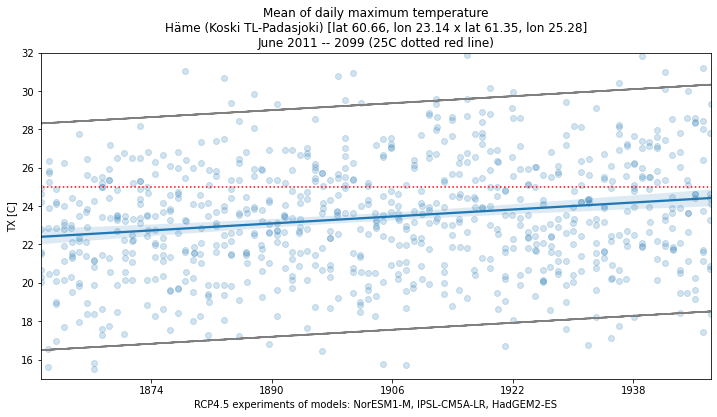

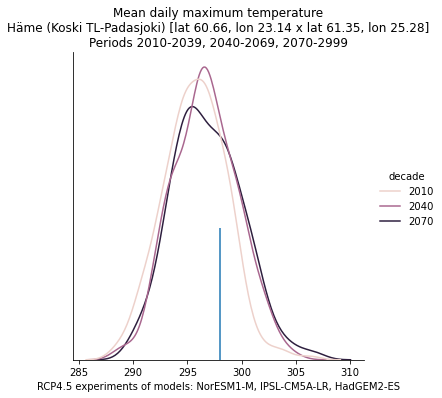

In [66]:

df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['hame'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
].copy()
new_df = fix_tx_datetime(df)

new_df['year'] = new_df['datetime'].dt.year

timeadjust = 0
xtra_txt = '\nJune 2011 -- 2099 (25C dotted red line)'

df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['hame'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
].copy()
df['year'] = df['datetime'].dt.year
sbry.plot_max_temp_trend(df, geo_hame, xtra_txt, 25, timeadjust)
sbry.plot_gdd_histogram(new_df, 'year', 'var', geo_hame, var_name, var_unit, 
                        '\nPeriods 2010-2039, 2040-2069, 2070-2999', 273 + 25)

1860-06-10 00:00:00
2011-01-05 00:00:00
                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     31.82
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.34e-08
Time:                        11:51:24   Log-Likelihood:                -2011.8
No. Observations:                 801   AIC:                             4028.
Df Residuals:                     799   BIC:                             4037.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const   

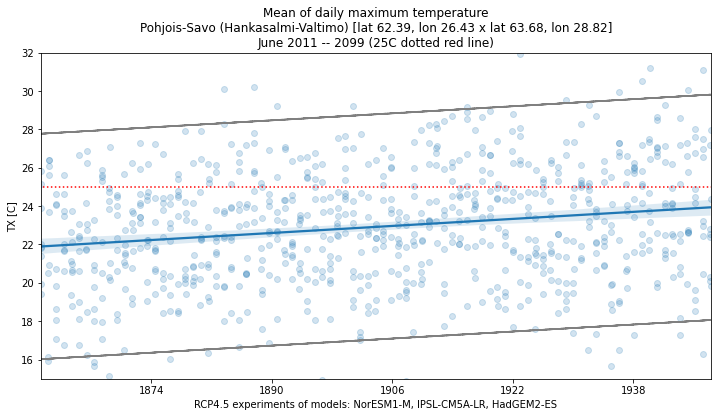

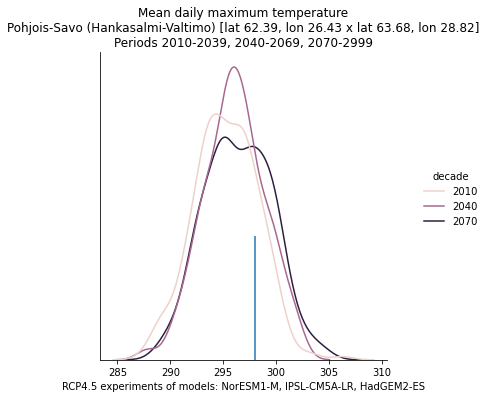

In [67]:
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['psavo'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
].copy()
new_df = fix_tx_datetime(df)

new_df['year'] = new_df['datetime'].dt.year

sbry.plot_max_temp_trend(df, geo_psavo, xtra_txt, 25, timeadjust)
sbry.plot_gdd_histogram(new_df, 'year', 'var', geo_psavo, var_name, 
                        var_unit, '\nPeriods 2010-2039, 2040-2069, 2070-2999', 273 + 25)

1860-06-10 00:00:00
2011-01-05 00:00:00
                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     39.67
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           4.95e-10
Time:                        11:51:43   Log-Likelihood:                -1890.0
No. Observations:                 801   AIC:                             3784.
Df Residuals:                     799   BIC:                             3793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const   

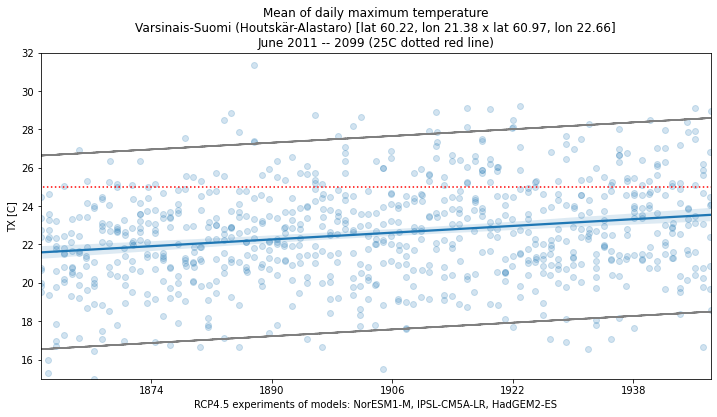

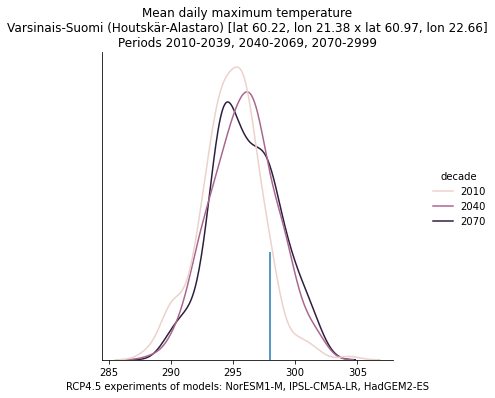

In [68]:
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TX') &
    (df_dekadal_long['region'].isin(['vsuomi'])) &
    ((df_dekadal_long['datetime'].dt.month.isin([6])))
].copy()
new_df = fix_tx_datetime(df)

new_df['year'] = new_df['datetime'].dt.year

sbry.plot_max_temp_trend(df, geo_vsuomi, xtra_txt, 25, timeadjust)
sbry.plot_gdd_histogram(
    new_df, 
    'year', 
    'var', 
    geo_vsuomi, 
    var_name, 
    var_unit, 
    '\nPeriods 2010-2039, 2040-2069, 2070-2999',
    273 + 25
)

## 2011-2041 <a id='mean_daily_temp_2011_2041'></a>


                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     8.268
Date:                Mon, 14 Sep 2020   Prob (F-statistic):            0.00436
Time:                        11:25:15   Log-Likelihood:                -666.73
No. Observations:                 270   AIC:                             1337.
Df Residuals:                     268   BIC:                             1345.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           19.3014      1.142     16.897   

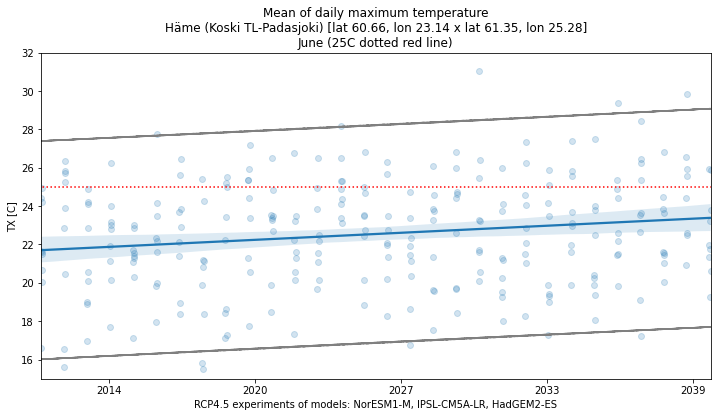

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     7.205
Date:                Mon, 14 Sep 2020   Prob (F-statistic):            0.00772
Time:                        11:25:17   Log-Likelihood:                -677.21
No. Observations:                 270   AIC:                             1358.
Df Residuals:                     268   BIC:                             1366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.9061      1.188     15.920   

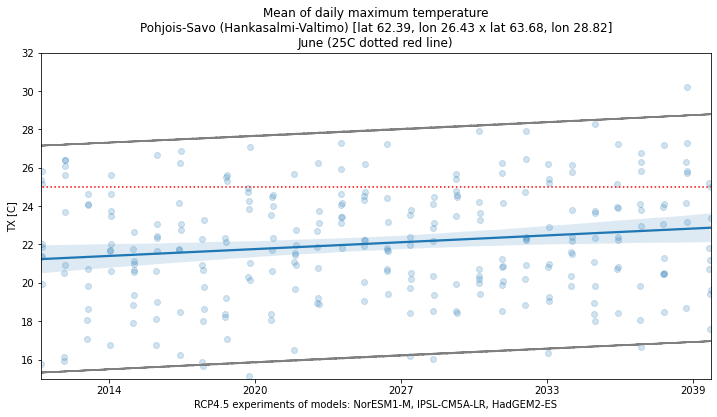

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     12.72
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           0.000429
Time:                        11:25:19   Log-Likelihood:                -623.61
No. Observations:                 270   AIC:                             1251.
Df Residuals:                     268   BIC:                             1258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           18.2256      0.974     18.718   

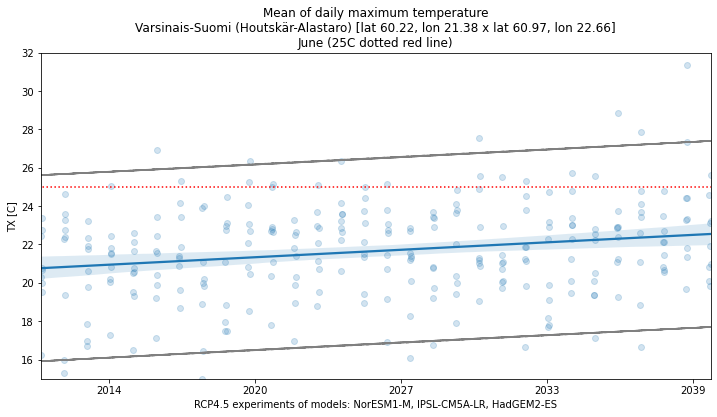

In [48]:
df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['hame'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]

sbry.plot_max_temp_trend(df, geo_hame, '\nJune (25C dotted red line)', 25)

df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['psavo'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]

sbry.plot_max_temp_trend(df, geo_psavo, '\nJune (25C dotted red line)', 25)

df = df_all.loc[
    (df_all['var_id'] == 'TX') &
    (df_all['region'].isin(['vsuomi'])) &
    ((df_all['datetime'].dt.month.isin([6])))
]
sbry.plot_max_temp_trend(df, geo_vsuomi, '\nJune (25C dotted red line)', 25)

# Accumulated temperature sum <a id='accum_temp_sum'></a>



## Full year 2011-2041 <a id='accum_temp_year'></a>

Fairly close to te official data for 2019 at https://www.ilmatieteenlaitos.fi/kasvukausi-2019

In [51]:
T_base = 5
df = df_all.loc[
    (df_all['var_id'] == 'TG')  #& ((df_all['datetime'].dt.month.isin([5])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

    datetime         var      model region  srctype  year       TG_C  GDD
0 2011-01-05  255.089951  NorESM1-M  psavo  dekadal  2011 -17.910049  0.0
1 2011-01-15  252.287477  NorESM1-M  psavo  dekadal  2011 -20.712523  0.0
2 2011-01-25  266.663320  NorESM1-M  psavo  dekadal  2011  -6.336680  0.0
3 2011-02-05  266.250922  NorESM1-M  psavo  dekadal  2011  -6.749078  0.0
4 2011-02-15  264.080629  NorESM1-M  psavo  dekadal  2011  -8.919371  0.0
5 2011-02-25  266.671358  NorESM1-M  psavo  dekadal  2011  -6.328642  0.0
6 2011-03-05  269.586945  NorESM1-M  psavo  dekadal  2011  -3.413055  0.0
7 2011-03-15  275.876294  NorESM1-M  psavo  dekadal  2011   2.876294  0.0
8 2011-03-25  272.299251  NorESM1-M  psavo  dekadal  2011  -0.700749  0.0
9 2011-04-05  276.937569  NorESM1-M  psavo  dekadal  2011   3.937569  0.0


                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     44.23
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.38e-09
Time:                        11:27:50   Log-Likelihood:                -573.19
No. Observations:                  90   AIC:                             1150.
Df Residuals:                      88   BIC:                             1155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.176e+04   3521.373     -6.181      0.0

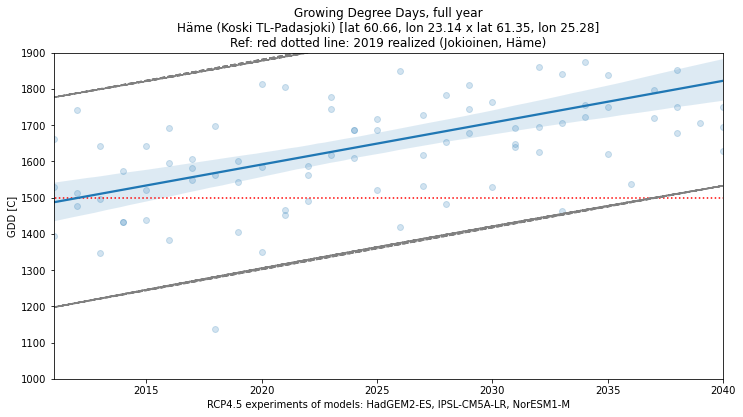

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     48.31
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           6.08e-10
Time:                        11:27:52   Log-Likelihood:                -573.70
No. Observations:                  90   AIC:                             1151.
Df Residuals:                      88   BIC:                             1156.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -2.3e+04   3541.314     -6.493      0.0

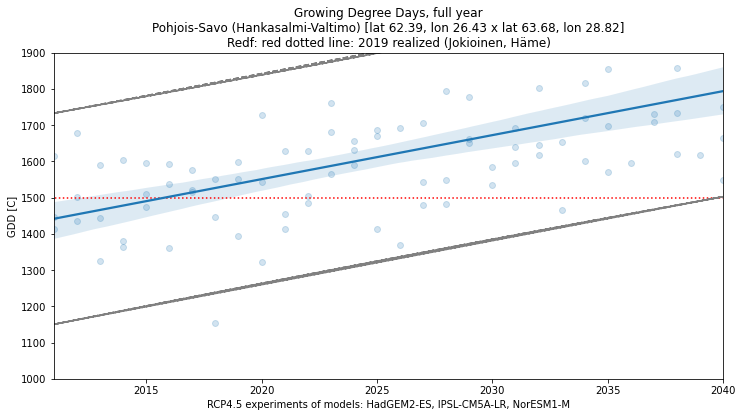

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     48.99
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           4.86e-10
Time:                        11:27:55   Log-Likelihood:                -572.86
No. Observations:                  90   AIC:                             1150.
Df Residuals:                      88   BIC:                             1155.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.284e+04   3508.254     -6.511      0.0

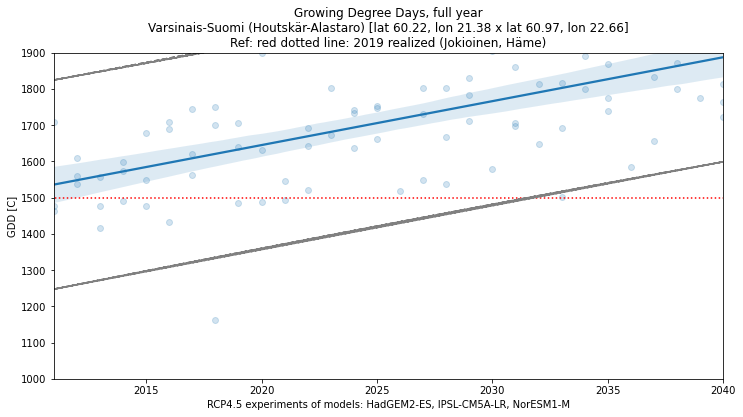

In [52]:
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_hame, 'Growing Degree Days, full year', 'C', '\nRef: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_psavo, 'Growing Degree Days, full year', 'C', '\nRedf: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_vsuomi, 'Growing Degree Days, full year', 'C', '\nRef: red dotted line: 2019 realized (Jokioinen, Häme)', 1500)

## 1st of May - 31 August - 2011-2099 <a id='accum_temp_2011_2099'></a>



In [57]:
T_base = 5
df = df_dekadal_long.loc[
    (df_dekadal_long['var_id'] == 'TG') & ((df_dekadal_long['datetime'].dt.month.isin([5, 6, 7, 8])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

     datetime         var      model region  srctype  year       TG_C  \
12 2011-05-05  277.263694  NorESM1-M  psavo  dekadal  2011   4.263694   
13 2011-05-15  287.142450  NorESM1-M  psavo  dekadal  2011  14.142450   
14 2011-05-25  287.547015  NorESM1-M  psavo  dekadal  2011  14.547015   
15 2011-06-05  289.739296  NorESM1-M  psavo  dekadal  2011  16.739296   
16 2011-06-15  289.672721  NorESM1-M  psavo  dekadal  2011  16.672721   
17 2011-06-25  293.034027  NorESM1-M  psavo  dekadal  2011  20.034027   
18 2011-07-05  290.556276  NorESM1-M  psavo  dekadal  2011  17.556276   
19 2011-07-15  293.747351  NorESM1-M  psavo  dekadal  2011  20.747351   
20 2011-07-25  292.598643  NorESM1-M  psavo  dekadal  2011  19.598643   
21 2011-08-05  289.480347  NorESM1-M  psavo  dekadal  2011  16.480347   

           GDD  
12    0.000000  
13   91.424500  
14   95.470154  
15  117.392965  
16  116.727214  
17  150.340271  
18  125.562764  
19  157.473511  
20  145.986430  
21  114.803467  


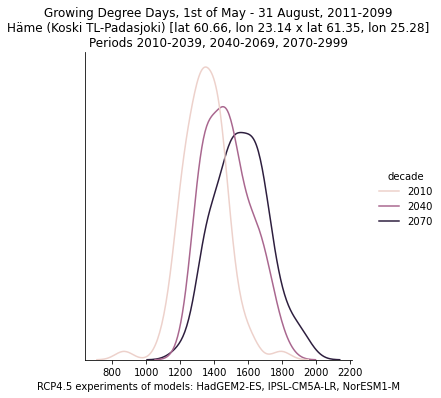

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     133.0
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           3.30e-25
Time:                        11:46:08   Log-Likelihood:                -1689.9
No. Observations:                 267   AIC:                             3384.
Df Residuals:                     265   BIC:                             3391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6227.8719    666.738     -9.341      0.0

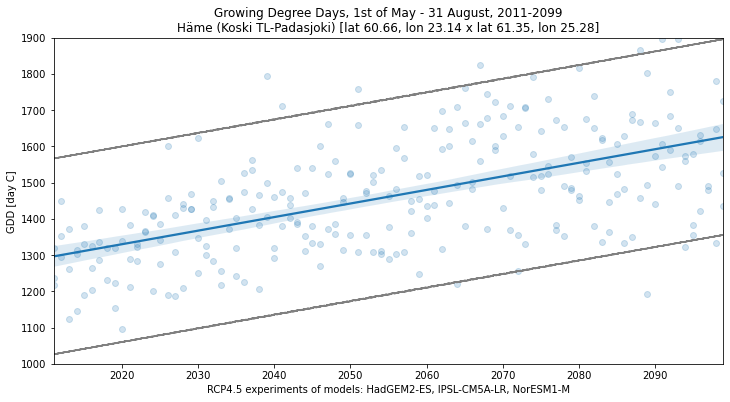

In [61]:
importlib.reload(sbry)

var_name = 'Growing Degree Days, 1st of May - 31 August, 2011-2099'
var_unit = 'day C'
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_histogram(df_grp, 'year', 'GDD', geo_hame, var_name, var_unit, '\nPeriods 2010-2039, 2040-2069, 2070-2999')
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_hame, var_name, var_unit, '')

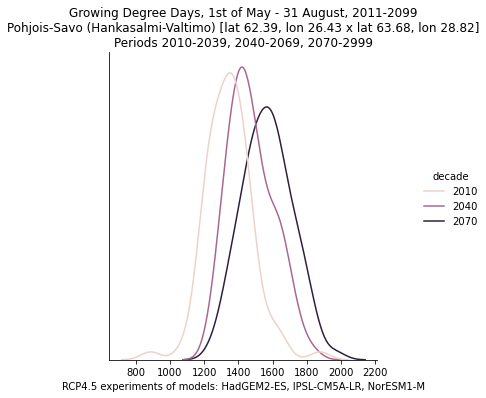

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     155.2
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.34e-28
Time:                        11:46:40   Log-Likelihood:                -1679.5
No. Observations:                 267   AIC:                             3363.
Df Residuals:                     265   BIC:                             3370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6525.1430    641.261    -10.175      0.0

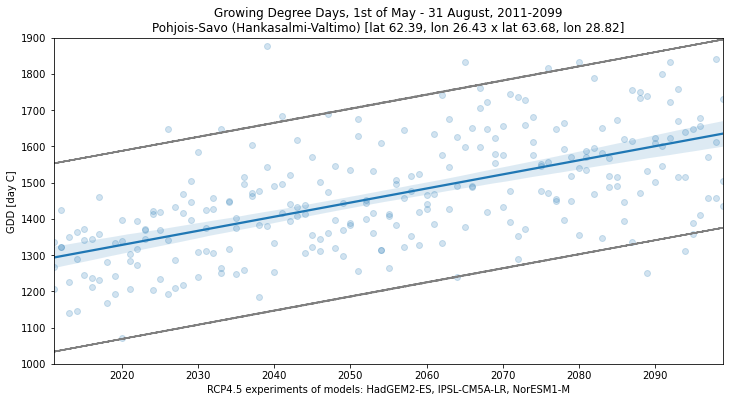

In [62]:
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_histogram(df_grp, 'year', 'GDD', geo_psavo, var_name, var_unit, '\nPeriods 2010-2039, 2040-2069, 2070-2999')
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_psavo, var_name, var_unit, '')

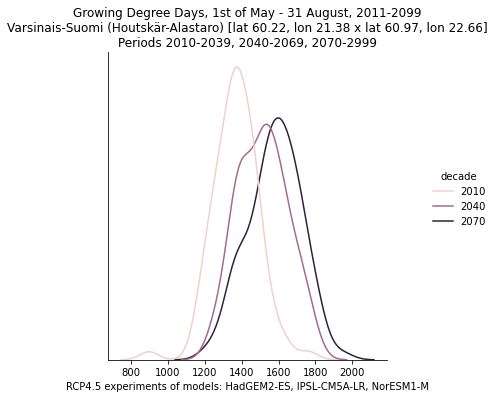

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     138.0
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           6.23e-26
Time:                        11:46:59   Log-Likelihood:                -1674.9
No. Observations:                 267   AIC:                             3354.
Df Residuals:                     265   BIC:                             3361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5915.4505    630.263     -9.386      0.0

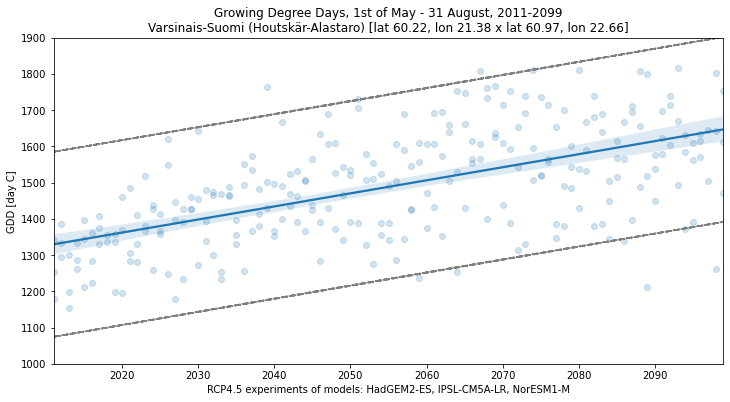

In [63]:
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_histogram(df_grp, 'year', 'GDD', geo_vsuomi, var_name, var_unit, '\nPeriods 2010-2039, 2040-2069, 2070-2999')
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_vsuomi, var_name, var_unit, '')

## 1st of May - 31 August - 2011-2041 <a id='accum_temp_2011_2041'></a>

Earlier run part, not checked/run in the latest iteration


In [55]:
T_base = 5
df = df_all.loc[
    (df_all['var_id'] == 'TG') & ((df_all['datetime'].dt.month.isin([5, 6, 7, 8])))
][['datetime', 'var', 'model', 'region', 'srctype']]
df['year'] = df['datetime'].dt.year
df['TG_C'] = df['var'] - 273
# each TG is from decadal data (for a 10 day period) ==> 10 * to get it (roughly) for whole year
df['GDD'] = [10*(x-T_base) if x > T_base else 0  for x in df['TG_C']]
print(df.head(10))

     datetime         var      model region  srctype  year       TG_C  \
12 2011-05-05  277.263694  NorESM1-M  psavo  dekadal  2011   4.263694   
13 2011-05-15  287.142450  NorESM1-M  psavo  dekadal  2011  14.142450   
14 2011-05-25  287.547015  NorESM1-M  psavo  dekadal  2011  14.547015   
15 2011-06-05  289.739296  NorESM1-M  psavo  dekadal  2011  16.739296   
16 2011-06-15  289.672721  NorESM1-M  psavo  dekadal  2011  16.672721   
17 2011-06-25  293.034027  NorESM1-M  psavo  dekadal  2011  20.034027   
18 2011-07-05  290.556276  NorESM1-M  psavo  dekadal  2011  17.556276   
19 2011-07-15  293.747351  NorESM1-M  psavo  dekadal  2011  20.747351   
20 2011-07-25  292.598643  NorESM1-M  psavo  dekadal  2011  19.598643   
21 2011-08-05  289.480347  NorESM1-M  psavo  dekadal  2011  16.480347   

           GDD  
12    0.000000  
13   91.424500  
14   95.470154  
15  117.392965  
16  116.727214  
17  150.340271  
18  125.562764  
19  157.473511  
20  145.986430  
21  114.803467  


                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     20.02
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           2.28e-05
Time:                        11:29:12   Log-Likelihood:                -554.93
No. Observations:                  90   AIC:                             1114.
Df Residuals:                      88   BIC:                             1119.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.152e+04   2874.593     -4.008      0.0

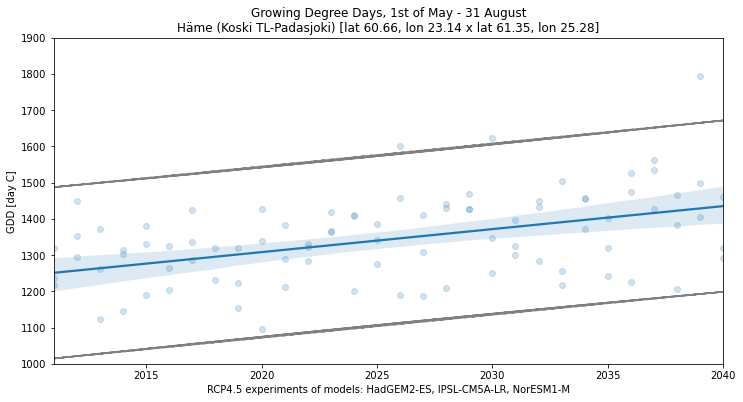

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     21.47
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           1.24e-05
Time:                        11:29:13   Log-Likelihood:                -559.82
No. Observations:                  90   AIC:                             1124.
Df Residuals:                      88   BIC:                             1129.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.272e+04   3035.023     -4.190      0.0

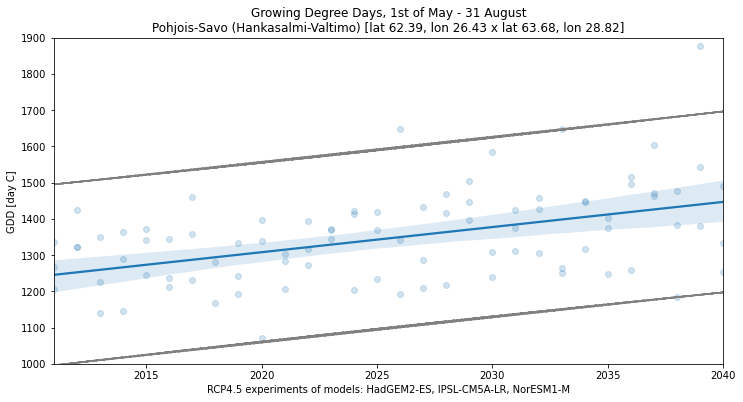

                            OLS Regression Results                            
Dep. Variable:                    GDD   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     27.93
Date:                Mon, 14 Sep 2020   Prob (F-statistic):           9.03e-07
Time:                        11:29:15   Log-Likelihood:                -547.08
No. Observations:                  90   AIC:                             1098.
Df Residuals:                      88   BIC:                             1103.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.255e+04   2634.518     -4.765      0.0

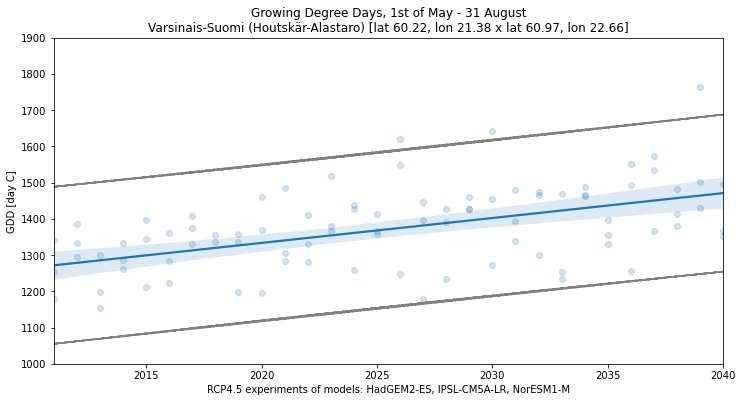

In [56]:
var_name = 'Growing Degree Days, 1st of May - 31 August'
var_unit = 'day C'
df_grp = df.loc[df['region'] == 'hame'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_hame, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'psavo'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_psavo, var_name, var_unit, '')
df_grp = df.loc[df['region'] == 'vsuomi'].groupby(['model', 'year'], as_index=False)['GDD'].sum()
sbry.plot_gdd_trend(df_grp, 'year', 'GDD', geo_vsuomi, var_name, var_unit, '')